In [1]:
import pyNUISANCE as pn
import numpy as np
import pyProSelecta as pps

In [2]:
dir(pn.response)

['GaussRBFInterpol',
 'NaturalCubicFrameSpline',
 '__doc__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__']

In [3]:
x = np.array([0,1,2,5.0/2.0,5])
y = np.array([[0,1,8,9,-5]])
sp = pn.response.NaturalCubicFrameSpline()
sp.build(x,y)

rbf = pn.response.GaussRBFInterpol()
rbf.build(x,y)

In [4]:
print(sp.coeffs)
print(rbf.coeffs)

[[ 0.00000000e+00  1.00000000e+00  8.00000000e+00  9.00000000e+00
  -1.04153846e+00  5.08307692e+00  4.70923077e+00 -1.69230769e-01
  -6.66133815e-16  6.12461538e+00 -6.49846154e+00 -3.25846154e+00
   2.04153846e+00 -4.20769231e+00  2.16000000e+00  4.34461538e-01]]
[[-0.0510752   0.6197814   4.39101862  6.64742265 -5.00000109]]


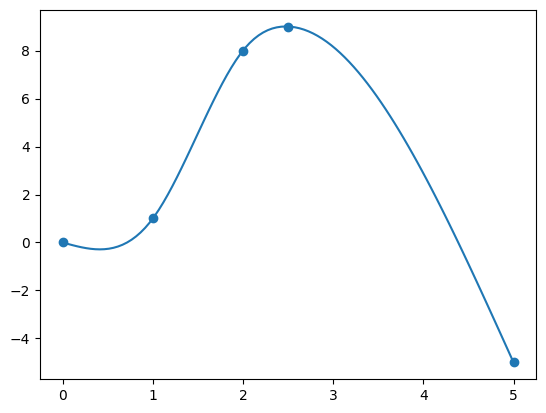

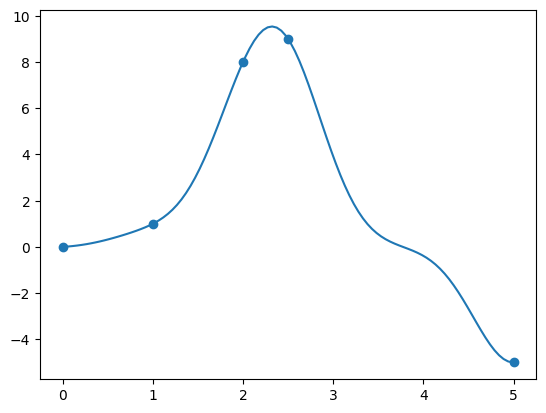

In [5]:
import matplotlib.pyplot as plt

xi = np.linspace(0.01,4.99,100)
yi = []
for x in xi:
    yi.append(sp.eval(x))
    
plt.plot(xi,yi)
plt.scatter([0,1,2,5.0/2.0,5],[0,1,8,9,-5])
plt.show()

xi = np.linspace(0.01,4.99,100)
yi = []
for x in xi:
    yi.append(rbf.eval([x,]))

plt.plot(xi,yi)
plt.scatter([0,1,2,5.0/2.0,5],[0,1,8,9,-5])
plt.show()

In [ ]:
evs = pn.EventSource("neutvect.t2kflux_numu_C_nofsi.root")
if not evs:
    print("Error: failed to open input file")

In [2]:
wf = pn.WeightCalcFactory()
nrw = wf.make(evs, {"plugin_name":"NReWeight", "neut_cardname": "neut.t2kflux_numu_C_nofsi.card"})

NameError: name 'evs' is not defined

In [ ]:
pps.load_text("""

std::vector<double> kinvars(HepMC3::GenEvent const &ev){
  std::vector<double> rtn(6,0xdeadbeef);

  if(!ps::event::has_beam_part(ev,14)) {
      return rtn;
  }
  auto const &nu = ps::event::beam_part(ev,14);

  if(!ps::event::has_out_part(ev,13)) {
      return rtn;
  }
  auto const &mu = ps::event::hm_out_part(ev,13);

  auto qv = nu->momentum() - mu->momentum();

  rtn[0] = nu->momentum().e()  / ps::unit::GeV;
  rtn[1] = qv.e() / ps::unit::GeV;
  rtn[2] = qv.p3mod() / ps::unit::GeV;
  rtn[3] = -qv.interval() / (ps::unit::GeV2);

  rtn[4] = mu->momentum().p3mod() / ps::unit::GeV;
  rtn[5] = std::cos(mu->momentum().theta());

  return rtn;
}

int isCCRes(HepMC3::GenEvent const &ev){
    return ps::event::signal_process_id(ev) == 400;
}
""")

In [ ]:
mares_vals = np.linspace(0.8,1.2,5)
ca5vals_vals = np.linspace(0.8,1.2,5)

ParamVals = []

for i in mares_vals:
    for j in ca5vals_vals:
        ParamVals.append((i,j))

def wghts(ev):
    resp = []
    for ma,ca in ParamVals:
        nrw.set_parameters({"MaRES":ma, "CA5RES":ca})
        resp.append(nrw.calc_weight(ev))
    return resp

In [ ]:
fg = pn.EventFrameGen(evs, 250000)\
  .filter(pps.select.get("isCCRes")) \
  .add_columns(["enu","q0","q3","Q2lep","plep","cthetalep"], pps.project.get_vect("kinvars")) \
  .add_columns(["MaRES=%s,CA5RES=%s" % (ma,ca) for ma,ca in ParamVals], wghts)

In [ ]:
ef = fg.first(int(5))

In [ ]:
print(ef)

In [ ]:
A = np.linspace(-3,3,20)
M_X, M_Y = np.meshgrid(A, A)
M_Z = np.empty(M_X.shape)

def f(x,y):
    return (np.sin(x))*np.cos(y)

P, Y = [], []
for i in range(M_X.shape[0]):
    for j in range(M_X.shape[1]):
        P.append((M_X[i,j],M_Y[i,j]))
        Y.append(f(M_X[i,j],M_Y[i,j]))

rbf.build(np.array(P),np.array([Y,]))

In [ ]:
X1, Y1 = np.array(P).transpose()
Z1 = Y

In [ ]:
A = np.linspace(-3,3,50)
M_X, M_Y = np.meshgrid(A, A)
M_Z = np.empty(M_X.shape)

for i in range(M_X.shape[0]):
    for j in range(M_X.shape[1]):
        M_Z[i,j] = rbf.eval([M_X[i,j], M_Y[i,j]])[0]

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X1, Y1, Z1, c="r")
ax.plot_wireframe(M_X, M_Y, M_Z, rstride=1, cstride=1)
plt.show()

In [ ]:
sp = pn.response.NaturalCubicFrameSpline()
sp.build(vals, ef.table[0:10,9:])
print(sp.coeffs)

In [ ]:
xi = np.linspace(0.801, 1.299, 100)
yi = np.array([sp.eval(v) for v in xi])
for i in range(10):
    plt.plot(xi,yi[:,i])
    plt.scatter(vals, ef.table[i,9:])

In [ ]:
eq2 = pn.HistFrame(pn.Binning.lin_space(0,2,25))
eq2.fill_weighted_columns_from_EventFrame(ef,["Q2lep"],ef.column_names[9:])


In [ ]:
eq2.mpl().hist_all(histtype="step")
plt.legend()
plt.show()

In [ ]:
sp = pn.response.NaturalCubicFrameSpline()
sp.build(vals,(eq2.sumweights[:,1:].transpose()/eq2.sumweights[:,0]).transpose())

In [ ]:
eq2_interp = pn.HistFrame(pn.Binning.lin_space(0,2,25))
eq2_interp.sumweights = eq2.sumweights[:,0]*sp.eval(1.1) 

eq2.mpl().hist_all(histtype="step")
eq2_interp.mpl().hist(histtype="step", label="Interp MaCCQE=0.9")
plt.legend()
plt.show()